#### [Source](https://www.kaggle.com/code/chibani410/gtsrb-99-test-accuracy-pytorch)

# Importing the required libraries

In [2]:
from torch.utils.data import Dataset,DataLoader,random_split
from typing import Any,Tuple,Optional,Callable
import PIL
import csv
import pathlib
import torch
import torch.nn as nn
from torch.optim import Adam,lr_scheduler
from torchvision.transforms import ToTensor,Resize,Compose,ColorJitter,RandomRotation,AugMix,RandomCrop,GaussianBlur,RandomEqualize,RandomHorizontalFlip,RandomVerticalFlip
import matplotlib.pyplot as plt
import pickle

# selecting our gpu accelerator

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Make a custom class for the gtsrb dataset

In [15]:
class GTSRB(Dataset):
    def __init__(self,
                 root: str,
                 split: str,
                 transform: Optional[Callable] = None):
       
        
        
        self.base_folder = pathlib.Path(root)
        self.csv_file = self.base_folder / ('Train.csv' if split =='train' else 'Test.csv')
        
        
        with open(str(self.csv_file)) as csvfile:
           samples = [(str(self.base_folder / row['Path']),int(row['ClassId'])) 
            for row in csv.DictReader(csvfile,delimiter=',',skipinitialspace=True)
                ]


        self.samples = samples
        self.split = split
        self.transform = transform

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index: int) -> Tuple:
        path,classId =  self.samples[index]
        sample = PIL.Image.open(path).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample,classId
     

# Augmenting our data by applying some transformations (brightness, contrast, vertical-horizontal flip, Rotations, Blur...)

In [16]:
train_transforms = Compose([
    ColorJitter(brightness=1.0, contrast=0.5, saturation=1, hue=0.1),
    RandomEqualize(0.4),
    AugMix(),
    RandomHorizontalFlip(0.3),
    RandomVerticalFlip(0.3),
    GaussianBlur((3,3)),
    RandomRotation(30),

    Resize([50,50]),
    ToTensor(),
    
])
validation_transforms =  Compose([
    Resize([50,50]),
    ToTensor(),
    
])

# splitting our dataset into train and validation 

In [17]:
def train_test_split(dataset,train_size):

    train_size = int(train_size * len(dataset))
    test_size = int(len(dataset) - train_size)
    return random_split(dataset,[train_size,test_size])

In [18]:
dataset = GTSRB(root='dataset',split="train")
train_set,validation_set = train_test_split(dataset,train_size=0.8)
print(f'training size : {len(train_set)}, Validation size : {len(validation_set)}')

training size : 31367, Validation size : 7842


# visualizing the data

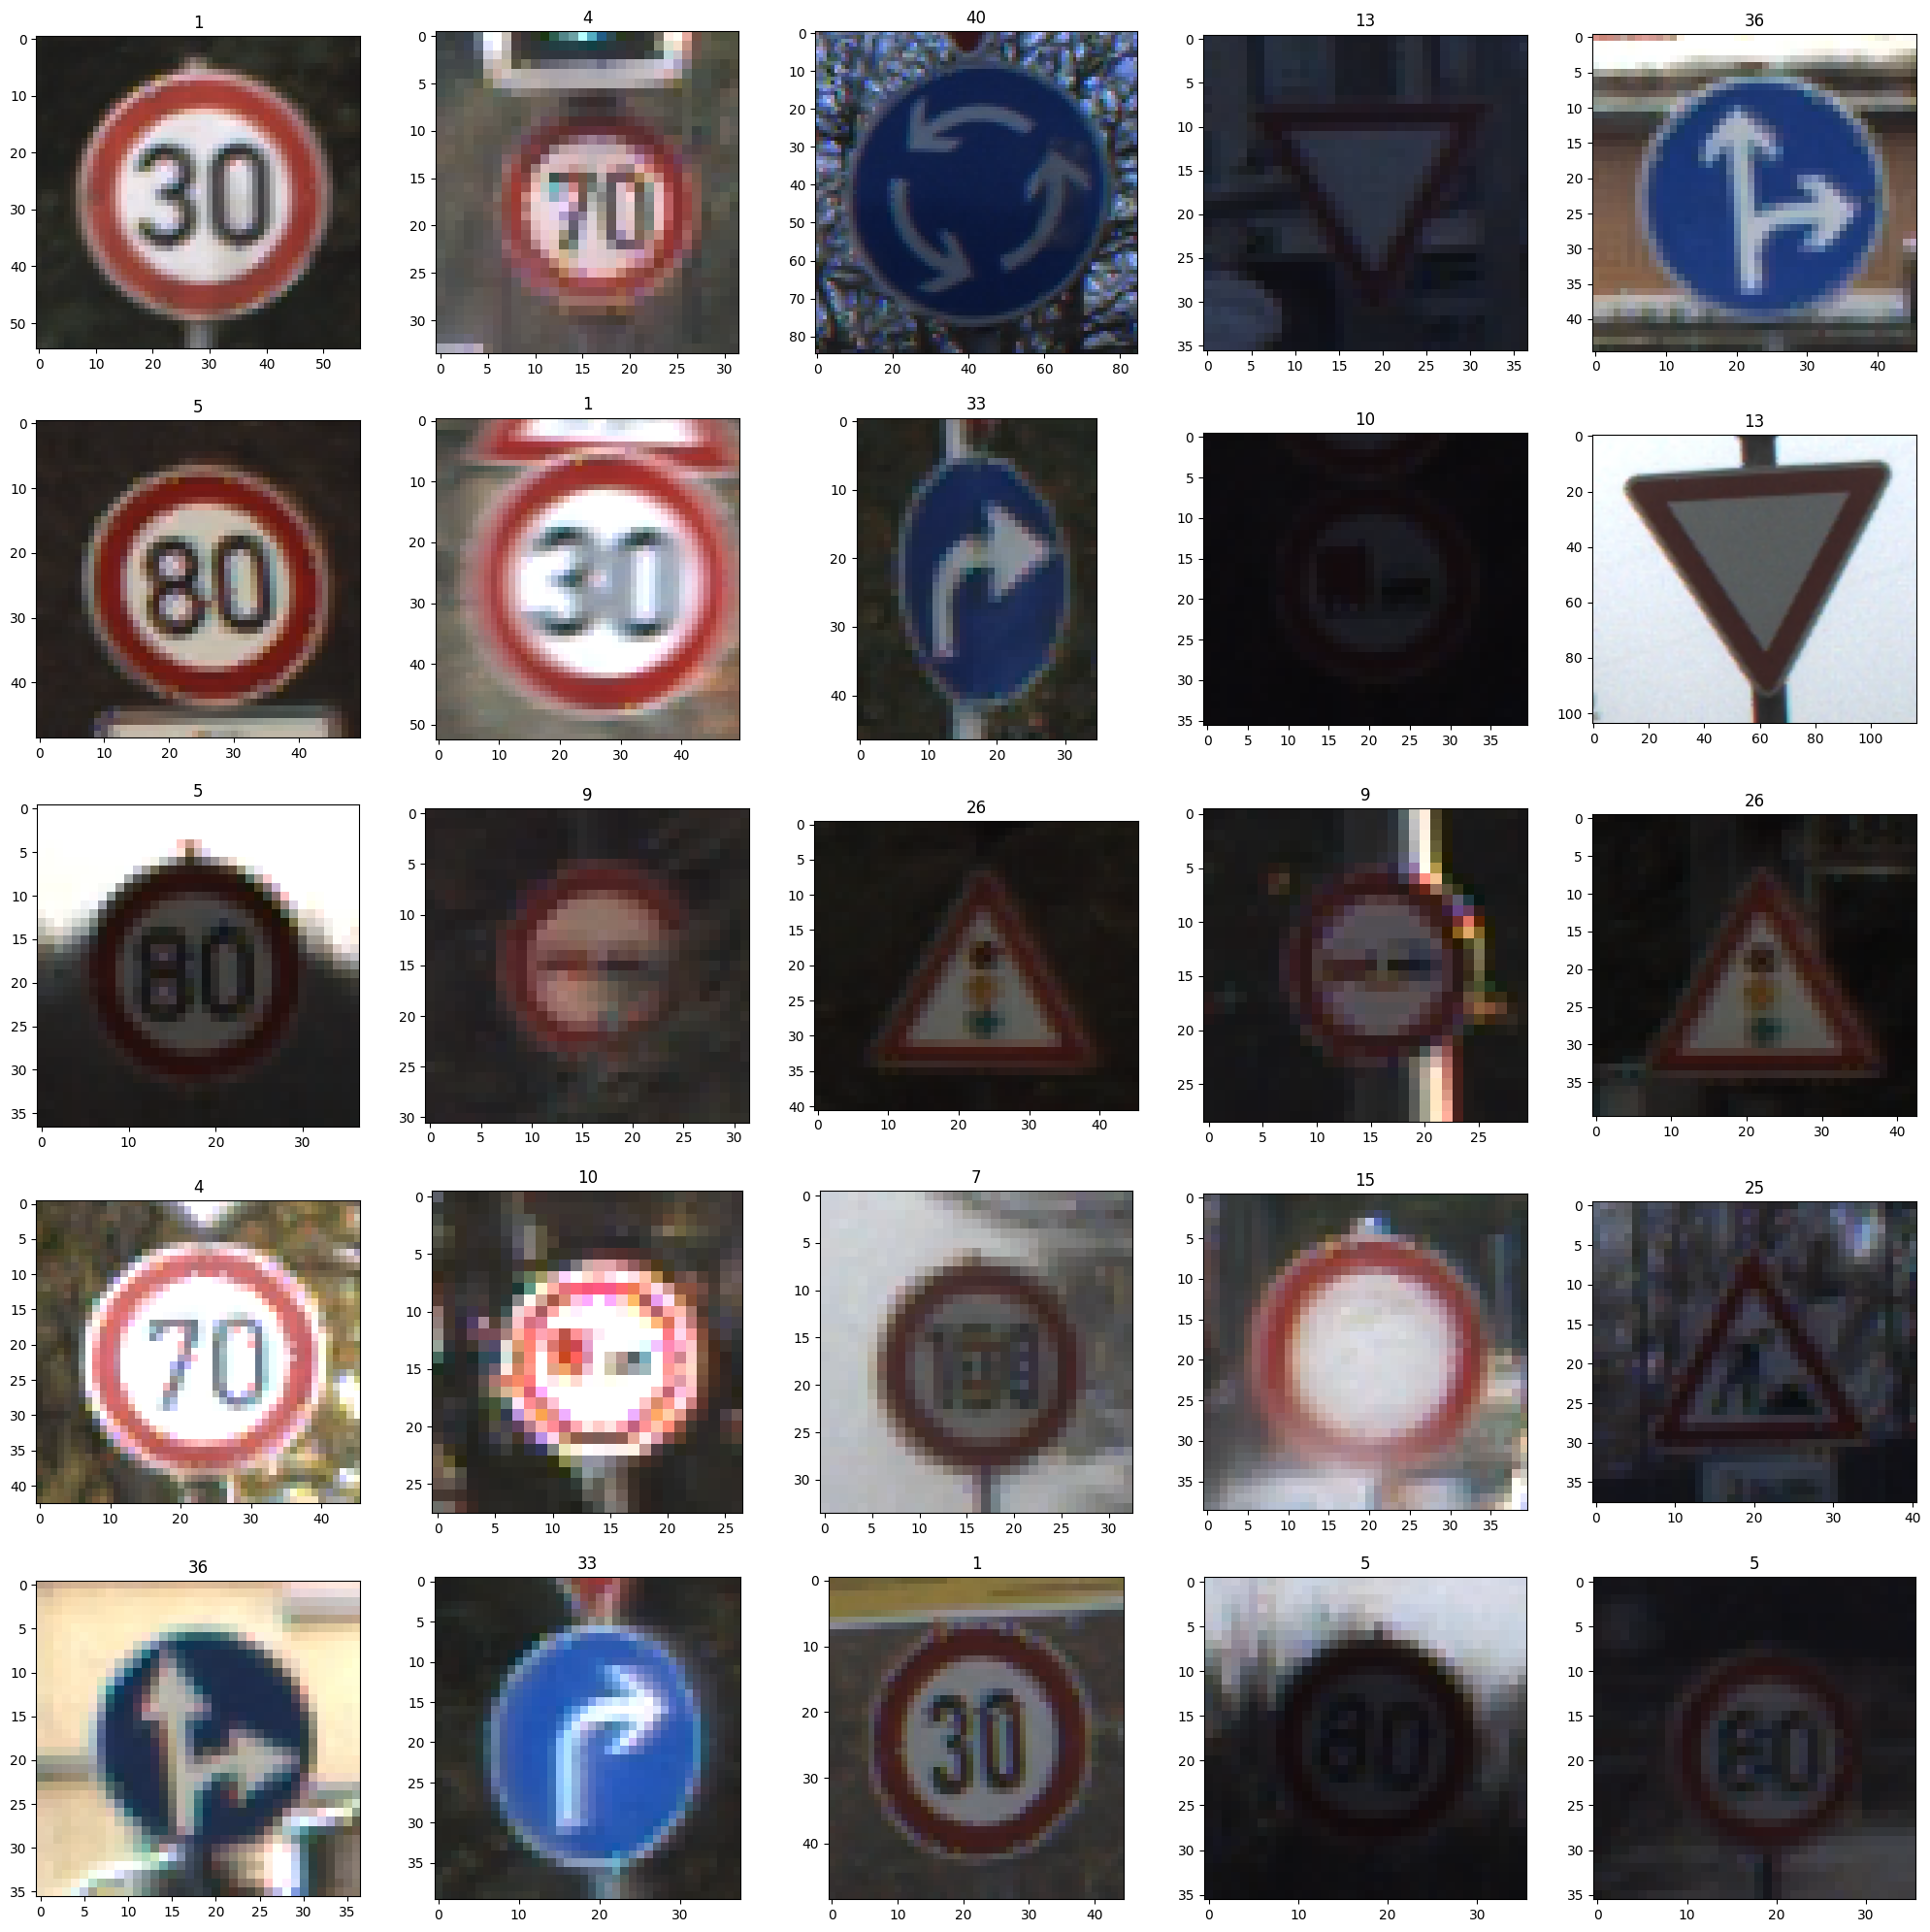

In [19]:
plt.figure(figsize=(25,25))
for i in range(1,26):
    input,label = train_set[i]
    plt.subplot(5,5,i)
    plt.title(label)
    plt.imshow(input)
    

# Applying the transformations

In [20]:
train_set.dataset.transform = train_transforms
validation_set.dataset.transform = validation_transforms

# Loading the data

In [21]:
BATCH_SIZE = 64
train_loader = DataLoader(dataset=train_set,batch_size=BATCH_SIZE,shuffle=True)
validation_loader = DataLoader(dataset=validation_set,batch_size=BATCH_SIZE)

# Building a convolutional neural network model

In [22]:
class GTSRB_MODEL(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(GTSRB_MODEL,self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
      
        self.metrics = {}
        
        self.flatten = nn.Flatten()
        
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.3)
       

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        

        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
        self.batchnorm2 = nn.BatchNorm2d(256)


        
        self.conv5 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3)
        self.conv6 = nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=3)
        self.batchnorm3 = nn.BatchNorm2d(1024)
        
       
       

        self.l1 = nn.Linear(1024*4*4,512)
        self.l2 = nn.Linear(512,128)
        self.batchnorm4 = nn.LayerNorm(128)
        self.l3 = nn.Linear(128,output_dim)
        
        
    def forward(self,input):
        
        conv = self.conv1(input)
        conv = self.conv2(conv)
        batchnorm = self.relu(self.batchnorm1(conv))
        maxpool = self.maxpool(batchnorm)

        conv = self.conv3(maxpool)
        conv = self.conv4(conv)
        batchnorm = self.relu(self.batchnorm2(conv))
        maxpool = self.maxpool(batchnorm)

        conv = self.conv5(maxpool)
        conv = self.conv6(conv)
        batchnorm = self.relu(self.batchnorm3(conv))
        maxpool = self.maxpool(batchnorm)
        
        
        
        
       
        
        flatten = self.flatten(maxpool)
        
        dense_l1 = self.l1(flatten)
        dropout = self.dropout3(dense_l1)
        dense_l2 = self.l2(dropout)
        batchnorm = self.batchnorm4(dense_l2)
        dropout = self.dropout2(batchnorm)
        output = self.l3(dropout)
        
       
        return output
    
    def training_metrics(self,positives,data_size,loss):
        acc = positives/data_size
        return loss,acc
    
    def validation_metrics(self,validation_data,loss_function):
       data_size = len(validation_data)
       correct_predictions = 0
       total_samples = 0
       val_loss = 0

       model = self.eval()
       with torch.no_grad() : 
        for step,(input,label) in enumerate(validation_data):
            input,label = input.to(device),label.to(device)
            prediction = model.forward(input)
            loss = loss_function(prediction,label)
            val_loss = loss.item()
            _,predicted = torch.max(prediction,1)
            correct_predictions += (predicted == label).sum().item()
            total_samples += label.size(0)

       val_acc = correct_predictions/total_samples

       return val_loss,val_acc

    def history(self):
        return self.metrics

            


    def compile(self,train_data,validation_data,epochs,loss_function,optimizer,learning_rate_scheduler):
        val_acc_list = []
        val_loss_list = []

        train_acc_list = []
        train_loss_list = []

        learning_rate_list = []

        print('training started ...')
        STEPS = len(train_data)
        for epoch in range(epochs):
            lr = optimizer.param_groups[0]["lr"]
            learning_rate_list.append(lr)
            correct_predictions = 0
            total_examples = 0
            loss = 0
            with tqdm.trange(STEPS) as progress:

                for step,(input,label) in enumerate(train_loader):

                    input,label = input.to(device),label.to(device)
                    prediction = self.forward(input)

                    _, predicted = torch.max(prediction, 1)
                    correct_predictions += (predicted == label).sum().item()
                    total_examples += label.size(0)
                    l = loss_function(prediction,label)
                    loss = l.item()
                    l.backward()
                    optimizer.step()
                    optimizer.zero_grad()

                    progress.colour = 'green'
                    progress.desc = f'Epoch [{epoch}/{EPOCHS}], Step [{step}/{STEPS}], Learning Rate [{lr}], Loss [{"{:.4f}".format(l)}], Accuracy [{"{:.4f}".format(correct_predictions/total_examples)}]'
                    progress.update(1)

            training_loss,training_acc = self.training_metrics(correct_predictions,total_examples,loss)
            train_acc_list.append(training_acc)
            train_loss_list.append(training_loss)

            val_loss, val_acc = self.validation_metrics(validation_data,loss_function)
            val_acc_list.append(val_acc)
            val_loss_list.append(val_loss)
            
            print(f'val_accuracy [{val_acc}], val_loss [{val_loss}]')

            
            learning_rate_scheduler.step()
        
        metrics_dict = {
                'train_acc':train_acc_list,
                'train_loss':train_loss_list,
                'val_acc':val_acc_list,
                'val_loss':val_loss_list,
                'learning_rate':optimizer.param_groups[0]["lr"]
            }
        self.metrics = metrics_dict
        print('training complete !')    

        

# Training our model

In [23]:
import tqdm
EPOCHS = 20
LEARNING_RATE = 0.0008
INPUT_DIM = 3*50*50
OUTPUT_DIM = 43
model = GTSRB_MODEL(INPUT_DIM,OUTPUT_DIM).to(device)

optimizer = Adam(params=model.parameters(),lr=LEARNING_RATE)
lr_s = lr_scheduler.LinearLR(optimizer,start_factor=1.0,end_factor=0.5,total_iters=10)
loss = nn.CrossEntropyLoss()


In [24]:
model.compile(train_data=train_loader,validation_data=validation_loader,epochs=EPOCHS,loss_function=loss,optimizer=optimizer,learning_rate_scheduler=lr_s)

training started ...


Epoch [0/20], Step [490/491], Learning Rate [0.0008], Loss [0.0492], Accuracy [0.7056]: 100%|███████████████████████████████| 491/491 [00:36<00:00, 13.41it/s]


val_accuracy [0.9535832695740882], val_loss [0.47100353240966797]


Epoch [1/20], Step [490/491], Learning Rate [0.00076], Loss [0.0041], Accuracy [0.9878]: 100%|██████████████████████████████| 491/491 [00:23<00:00, 21.13it/s]


val_accuracy [0.9955368528436623], val_loss [0.07231592386960983]


Epoch [2/20], Step [490/491], Learning Rate [0.00072], Loss [0.0045], Accuracy [0.9975]: 100%|██████████████████████████████| 491/491 [00:22<00:00, 21.35it/s]


val_accuracy [0.9922213720989543], val_loss [0.12631066143512726]


Epoch [3/20], Step [490/491], Learning Rate [0.00068], Loss [0.0014], Accuracy [0.9986]: 100%|██████████████████████████████| 491/491 [00:23<00:00, 21.24it/s]


val_accuracy [0.998342259627646], val_loss [0.004105846397578716]


Epoch [4/20], Step [490/491], Learning Rate [0.00064], Loss [0.0146], Accuracy [0.9966]: 100%|██████████████████████████████| 491/491 [00:23<00:00, 20.95it/s]


val_accuracy [0.9862280030604438], val_loss [0.09022565931081772]


Epoch [5/20], Step [490/491], Learning Rate [0.0006000000000000001], Loss [0.0004], Accuracy [0.9985]: 100%|████████████████| 491/491 [00:23<00:00, 21.31it/s]


val_accuracy [0.9979597041571028], val_loss [0.002908645197749138]


Epoch [6/20], Step [490/491], Learning Rate [0.0005600000000000001], Loss [0.0002], Accuracy [1.0000]: 100%|████████████████| 491/491 [00:23<00:00, 21.05it/s]


val_accuracy [0.998342259627646], val_loss [0.0006169601110741496]


Epoch [7/20], Step [490/491], Learning Rate [0.0005200000000000001], Loss [0.0000], Accuracy [1.0000]: 100%|████████████████| 491/491 [00:23<00:00, 21.33it/s]


val_accuracy [0.998342259627646], val_loss [0.0003813534276559949]


Epoch [8/20], Step [490/491], Learning Rate [0.00048000000000000007], Loss [0.0001], Accuracy [1.0000]: 100%|███████████████| 491/491 [00:23<00:00, 20.83it/s]


val_accuracy [0.998342259627646], val_loss [0.00030468794284388423]


Epoch [9/20], Step [490/491], Learning Rate [0.00044000000000000007], Loss [0.0001], Accuracy [1.0000]: 100%|███████████████| 491/491 [00:23<00:00, 20.54it/s]


val_accuracy [0.9985972966080081], val_loss [0.0002517722314223647]


Epoch [10/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0001], Accuracy [1.0000]: 100%|███████████████| 491/491 [00:23<00:00, 20.64it/s]


val_accuracy [0.9985972966080081], val_loss [0.00023615143436472863]


Epoch [11/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0000], Accuracy [1.0000]: 100%|███████████████| 491/491 [00:25<00:00, 19.57it/s]


val_accuracy [0.9985972966080081], val_loss [0.00020054045307915658]


Epoch [12/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0001], Accuracy [1.0000]: 100%|███████████████| 491/491 [00:23<00:00, 20.95it/s]


val_accuracy [0.9985972966080081], val_loss [0.0001431397395208478]


Epoch [13/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0000], Accuracy [1.0000]: 100%|███████████████| 491/491 [00:23<00:00, 21.30it/s]


val_accuracy [0.9985972966080081], val_loss [0.00011772024299716577]


Epoch [14/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0001], Accuracy [1.0000]: 100%|███████████████| 491/491 [00:23<00:00, 20.94it/s]


val_accuracy [0.9985972966080081], val_loss [0.00010199084499618039]


Epoch [15/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0000], Accuracy [1.0000]: 100%|███████████████| 491/491 [00:23<00:00, 20.89it/s]


val_accuracy [0.9985972966080081], val_loss [8.846311538945884e-05]


Epoch [16/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0001], Accuracy [1.0000]: 100%|███████████████| 491/491 [00:23<00:00, 21.15it/s]


val_accuracy [0.9985972966080081], val_loss [6.692354509141296e-05]


Epoch [17/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0000], Accuracy [1.0000]: 100%|███████████████| 491/491 [00:23<00:00, 21.18it/s]


val_accuracy [0.9985972966080081], val_loss [5.461829641717486e-05]


Epoch [18/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0000], Accuracy [1.0000]: 100%|███████████████| 491/491 [00:22<00:00, 21.49it/s]


val_accuracy [0.9985972966080081], val_loss [4.373586853034794e-05]


Epoch [19/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0000], Accuracy [1.0000]: 100%|███████████████| 491/491 [00:23<00:00, 20.89it/s]


val_accuracy [0.9985972966080081], val_loss [3.3178886951645836e-05]
training complete !


In [27]:
import pickle
f = open('gstrb-99-saved_model.pkl','wb')
pickle.dump(model,f)
f.close()

In [28]:
transforms = Compose([
    Resize([50,50]),
    ToTensor(),
    
])

testdata = GTSRB(root='./dataset',split='test',transform=transforms)
print('testing size :',len(testdata))
test_dataloader = DataLoader(testdata)




testing size : 12630


In [29]:
from sklearn.metrics import accuracy_score

y_pred = []
y_true = []
model = model.eval().to(device)
with tqdm.tqdm(colour='red',total=len(test_dataloader)) as progress:
  
  with torch.no_grad() : 
    for id,(input,label) in enumerate(iter(test_dataloader)):
        input,label = input.to(device),label.to(device)
        y_true.append(label.item())
        prediction = model.forward(input)
        _,prediction = torch.max(prediction,1)
        y_pred.append(prediction.item())
        
        progress.desc = f'Test Accuracy : {accuracy_score(y_true,y_pred)} '
        progress.update(1)
        
       

Test Accuracy : 0.9898653998416469 : 100%|█████████████████████████████████████████████████████████████████████████████| 12630/12630 [01:56<00:00, 108.52it/s]
